In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from sklearn.utils import class_weight

In [3]:
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [4]:
# charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../../../Facenet Embeddings/Train/X_train.npy'
path_val = '../../../Facenet Embeddings/Val/X_val.npy'
path_test = '../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)
## if in the first or second position exists a 1, then y is 0 and only has a shape of 1, else 1
##y_train = np.where((y_train[:, 3] == 1), 1, 0).reshape(-1, 1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)
##y_val = np.where((y_val[:, 3] == 1), 1, 0).reshape(-1, 1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

#y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
##y_test = np.where((y_test[:, 3] == 1), 1, 0).reshape(-1, 1)

X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [5]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5711, 5, 128), (1428, 5, 128), (1785, 5, 128), (5711,), (1428,), (1785,))

In [6]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [7]:
# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Definimos el modelo CNN
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    return model

# Creamos y entrenamos el modelo
model = build_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/500


d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2811 - loss: 1.5100 - val_accuracy: 0.3557 - val_loss: 1.3194 - learning_rate: 5.0000e-04
Epoch 2/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3083 - loss: 1.4033 - val_accuracy: 0.3803 - val_loss: 1.2837 - learning_rate: 5.0000e-04
Epoch 3/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3043 - loss: 1.4724 - val_accuracy: 0.3613 - val_loss: 1.2773 - learning_rate: 5.0000e-04
Epoch 4/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3038 - loss: 1.3691 - val_accuracy: 0.3613 - val_loss: 1.2496 - learning_rate: 5.0000e-04
Epoch 5/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3068 - loss: 1.4012 - val_accuracy: 0.3578 - val_loss: 1.2412 - learning_rate: 5.0000e-04
Epoch 6/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3316 - loss: 1.2464 - val_accuracy: 0.3810 - val_loss: 1.2228 - learning_rate: 5.0000e-04
Epoch 7/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.351

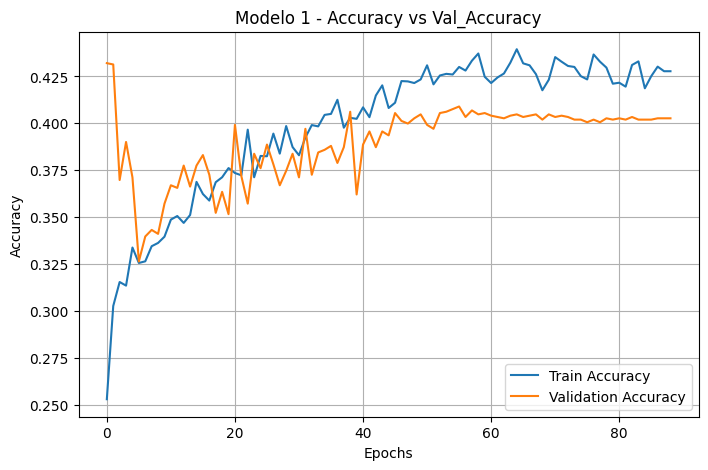

In [ ]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Modelo {1} - Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

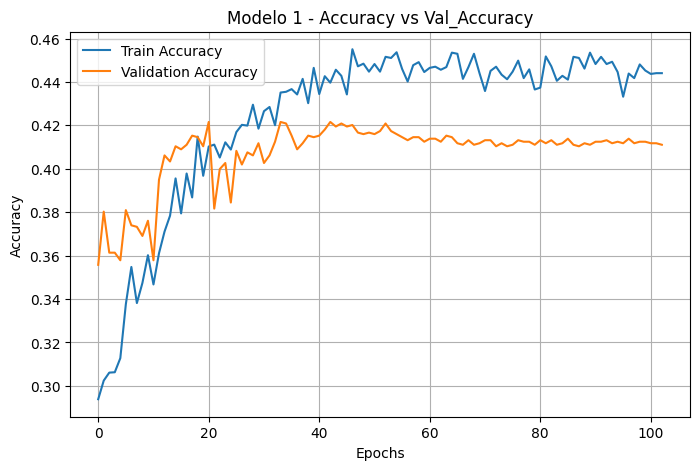

In [8]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Modelo {1} - Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

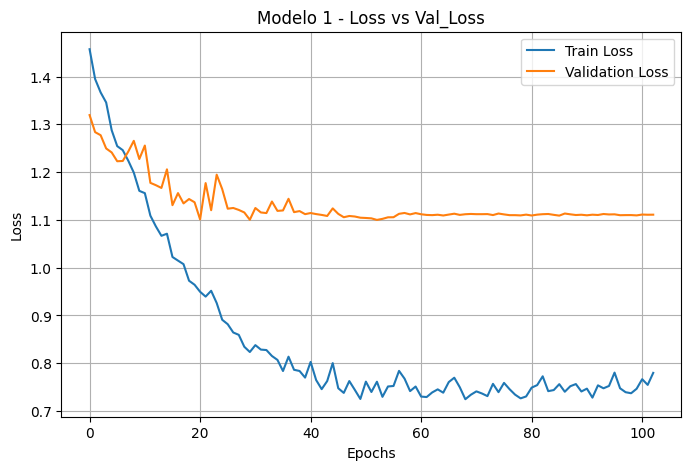

In [9]:
# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Modelo {1} - Loss vs Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Predicciones individuales de cada modelo
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


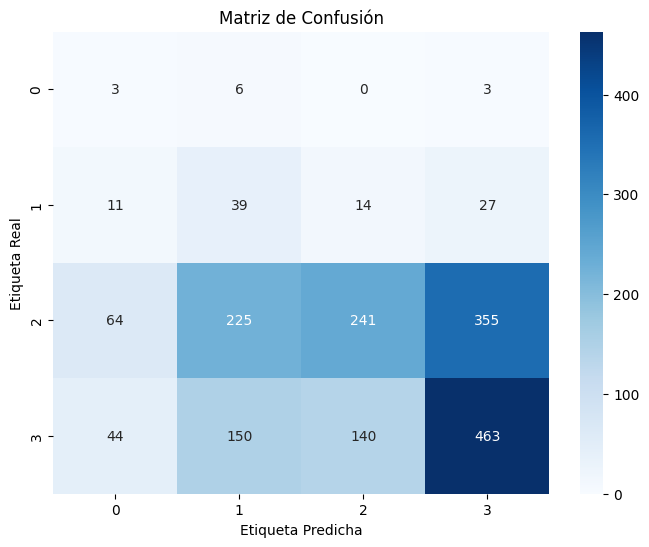

In [9]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

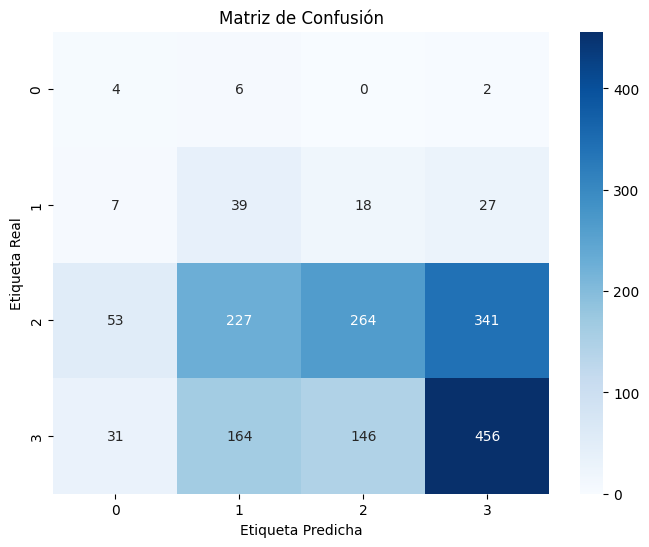

In [11]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [ ]:
# Classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.025     0.250     0.045        12
           1      0.093     0.429     0.153        91
           2      0.610     0.272     0.377       885
           3      0.546     0.581     0.563       797

    accuracy                          0.418      1785
   macro avg      0.318     0.383     0.284      1785
weighted avg      0.551     0.418     0.446      1785



In [ ]:
# Classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.042     0.333     0.075        12
           1      0.089     0.429     0.148        91
           2      0.617     0.298     0.402       885
           3      0.552     0.572     0.562       797

    accuracy                          0.427      1785
   macro avg      0.325     0.408     0.297      1785
weighted avg      0.557     0.427     0.458      1785



In [ ]:
# View UAR metric
def uar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar_score = uar(y_test, final_preds)
print(f'UAR: {uar_score:.4f}')